# Libraries

In [393]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

#for some statistics & math
import math
from scipy import stats
from scipy.stats import norm, skew 

#To deal with warnings
import warnings
warnings.filterwarnings("ignore")

# Modelling
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler # For normalization
import category_encoders as ce
from sklearn.model_selection import KFold


# Loading Datasets

In [354]:
#Now let's import and put the datasets
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
Submission = pd.read_csv("SampleSubmission.csv")
riders = pd.read_csv("Riders.csv")
dictionary = pd.read_csv('VariableDefinitions.csv')

In [355]:
# Viewing the datasets
display(train.head(3))
display(test.head(3))
display(riders.head(3))
display(dictionary.head())

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455


,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Pickup - Weekday (Mo = 1),Pickup - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id
0,Order_No_19248,User_Id_3355,Bike,3,Business,27,3,4:44:10 PM,27,3,...,3,5:06:47 PM,8,NaN,NaN,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192
1,Order_No_12736,User_Id_3647,Bike,3,Business,17,5,12:57:35 PM,17,5,...,5,1:25:37 PM,5,NaN,NaN,-1.272639,36.794723,-1.277007,36.823907,Rider_Id_868
2,Order_No_768,User_Id_2154,Bike,3,Business,27,4,11:08:14 AM,27,4,...,4,11:57:54 AM,5,22.8,NaN,-1.290894,36.822971,-1.276574,36.851365,Rider_Id_26


,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Rider_Id_396,2946,2298,14.0,1159
1,Rider_Id_479,360,951,13.5,176
2,Rider_Id_648,1746,821,14.3,466


,Order No,Unique number identifying the order
0,User Id,Unique number identifying the customer on a pl...
1,Vehicle Type,"For this competition limited to bikes, however..."
2,Platform Type,"Platform used to place the order, there are 4 ..."
3,Personal or Business,Customer type
4,Placement - Day of Month,Placement - Day of Month i.e 1-31


### Data description

In [356]:
# Checking unique values per column
display(train.nunique())
display(test.nunique())

Order No                                     21201
User Id                                       3186
Vehicle Type                                     1
Platform Type                                    4
Personal or Business                             2
Placement - Day of Month                        31
Placement - Weekday (Mo = 1)                     7
Placement - Time                             15686
Confirmation - Day of Month                     31
Confirmation - Weekday (Mo = 1)                  7
Confirmation - Time                          15742
Arrival at Pickup - Day of Month                31
Arrival at Pickup - Weekday (Mo = 1)             7
Arrival at Pickup - Time                     15767
Pickup - Day of Month                           31
Pickup - Weekday (Mo = 1)                        7
Pickup - Time                                15690
Arrival at Destination - Day of Month           31
Arrival at Destination - Weekday (Mo = 1)        7
Arrival at Destination - Time  

Order No                                7068
User Id                                 1617
Vehicle Type                               1
Platform Type                              4
Personal or Business                       2
Placement - Day of Month                  31
Placement - Weekday (Mo = 1)               7
Placement - Time                        6336
Confirmation - Day of Month               31
Confirmation - Weekday (Mo = 1)            7
Confirmation - Time                     6388
Arrival at Pickup - Day of Month          31
Arrival at Pickup - Weekday (Mo = 1)       7
Arrival at Pickup - Time                6374
Pickup - Day of Month                     31
Pickup - Weekday (Mo = 1)                  7
Pickup - Time                           6361
Distance (KM)                             41
Temperature                              182
Precipitation in millimeters              43
Pickup Lat                              1863
Pickup Long                             1858
Destinatio

In [357]:
# Dropping the Vehicle Type column (it has one unique value)
train.drop('Vehicle Type', axis=1, inplace=True)
test.drop('Vehicle Type', axis=1, inplace=True)

### Fixing Messy Columns names

In [358]:
def column_fix(input_df):
    input_df.columns = input_df.columns.str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('=', '_')
    input_df.columns = input_df.columns.str.replace('__', '_')
    input_df.columns = input_df.columns.str.replace('(', '').str.replace(')', '')
    input_df.columns = input_df.columns.str.replace('__', '_')
    display(input_df.columns)

# train dataset
column_fix(train)

#test dataset
column_fix(test)

#riders dataset
column_fix(riders)

Index(['order_no', 'user_id', 'platform_type', 'personal_or_business',
       'placement_day_of_month', 'placement_weekday_mo_1', 'placement_time',
       'confirmation_day_of_month', 'confirmation_weekday_mo_1',
       'confirmation_time', 'arrival_at_pickup_day_of_month',
       'arrival_at_pickup_weekday_mo_1', 'arrival_at_pickup_time',
       'pickup_day_of_month', 'pickup_weekday_mo_1', 'pickup_time',
       'arrival_at_destination_day_of_month',
       'arrival_at_destination_weekday_mo_1', 'arrival_at_destination_time',
       'distance_km', 'temperature', 'precipitation_in_millimeters',
       'pickup_lat', 'pickup_long', 'destination_lat', 'destination_long',
       'rider_id', 'time_from_pickup_to_arrival'],
      dtype='object')

Index(['order_no', 'user_id', 'platform_type', 'personal_or_business',
       'placement_day_of_month', 'placement_weekday_mo_1', 'placement_time',
       'confirmation_day_of_month', 'confirmation_weekday_mo_1',
       'confirmation_time', 'arrival_at_pickup_day_of_month',
       'arrival_at_pickup_weekday_mo_1', 'arrival_at_pickup_time',
       'pickup_day_of_month', 'pickup_weekday_mo_1', 'pickup_time',
       'distance_km', 'temperature', 'precipitation_in_millimeters',
       'pickup_lat', 'pickup_long', 'destination_lat', 'destination_long',
       'rider_id'],
      dtype='object')

Index(['rider_id', 'no_of_orders', 'age', 'average_rating', 'no_of_ratings'], dtype='object')

### Addressing Missing Values 

A **drop_columns** function will be employed to remove any column from the dataframes which has a percentage of missing values greater than a specified `cutoff threshold value`

In [359]:
def drop_columns(input_df, threshold):
    for column in input_df.columns:
        if ((input_df[column].isna().mean() * 100) > threshold):
            input_df.drop(column, axis = 1, inplace = True)
            print(f'The {column} column has been dropped')

In [360]:
# A threshold value of 70% is initially used
drop_columns(train, 70)

The precipitation_in_millimeters column has been dropped


In [361]:
# Test dataset
drop_columns(test, 70)

The precipitation_in_millimeters column has been dropped


Text(0.5, 1, 'Test missing values heatmap')

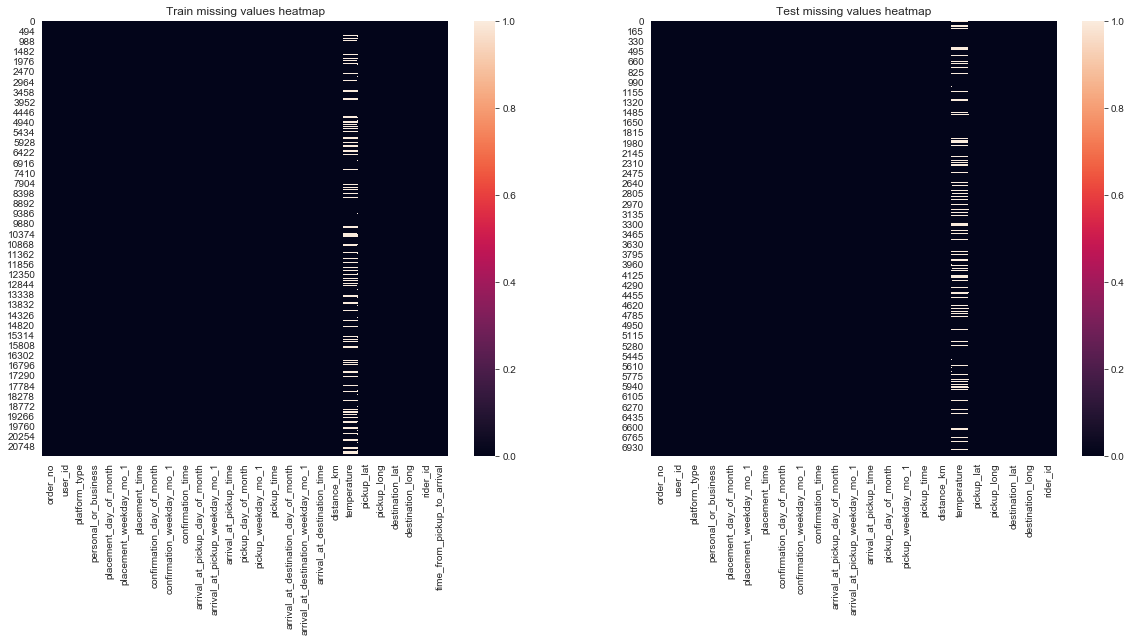

In [362]:
# Addressing columns that have missing values but their percentage is below the threshold value
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.heatmap(train.isna(), ax = ax[0])
sns.heatmap(test.isna(), ax = ax[1])
ax[0].set_title('Train missing values heatmap')
ax[1].set_title('Test missing values heatmap')

The Temperature column on both datasets has some missing values. Let's look at the distribution of the temperature values in order to gain good insight towards value imputation.

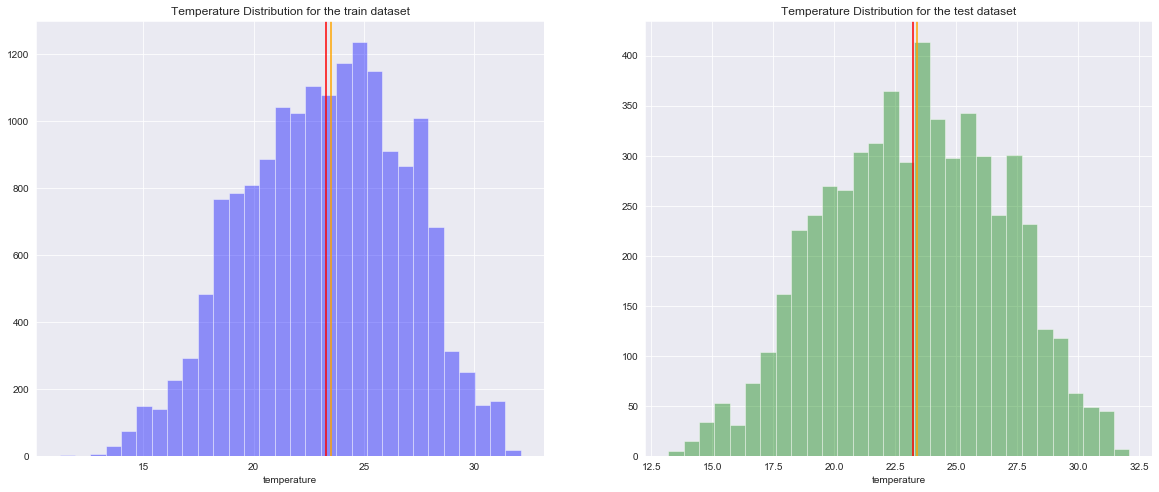

In [363]:
# Temperature distributions
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.distplot(train['temperature'], bins=30, color='blue', ax = ax[0], kde=False)
sns.distplot(test['temperature'], bins=30, color='green', ax = ax[1], kde=False)
ax[0].set_title('Temperature Distribution for the train dataset')
ax[1].set_title('Temperature Distribution for the test dataset')
ax[0].axvline(x=train['temperature'].mean(), color='red')
ax[0].axvline(x=train['temperature'].median(), color='orange')
ax[1].axvline(x=test['temperature'].mean(), color='red')
ax[1].axvline(x=test['temperature'].median(), color='orange')

The Temperature columns for both datasets are normally distributed thus it would be reasonable to impute the missing values with the mean values

In [364]:
train['temperature'].fillna(train['temperature'].mean(), inplace=True)
test['temperature'].fillna(test['temperature'].mean(), inplace=True)

### Time features 

The time features won't be of much help to us since the information they contain is still congested. The best approach would be to extract the hour, minute components.

In [365]:
train_time_cols = ['placement_time', 'confirmation_time', 'arrival_at_pickup_time', 'pickup_time', 'arrival_at_destination_time']
test_time_cols = ['placement_time', 'confirmation_time', 'arrival_at_pickup_time', 'pickup_time']
for col in train_time_cols:
    train[col] = pd.to_datetime(train[col])
    
for col in test_time_cols:
    test[col] = pd.to_datetime(test[col])

The placement_time and confirmation_time features can either be dropped or be used to create more weighty features. We will attemp to create more featured out of these.

In [366]:
train['placement_to_confirmation_duration'] =  (train['confirmation_time'] - train['placement_time']).astype('timedelta64[s]')
train['confirmation_to_arrivalpickup_duration'] = (train['arrival_at_pickup_time'] - train['confirmation_time']).astype('timedelta64[s]')
train['arrivalpickup_to_pickup_duration'] = (train['pickup_time'] - train['arrival_at_pickup_time']).astype('timedelta64[s]')

test['placement_to_confirmation_duration'] = (test['confirmation_time'] - test['placement_time']).astype('timedelta64[s]')
test['confirmation_to_arrivalpickup_duration'] = (test['arrival_at_pickup_time'] - test['confirmation_time']).astype('timedelta64[s]')
test['arrivalpickup_to_pickup_duration'] = (test['pickup_time'] - test['arrival_at_pickup_time']).astype('timedelta64[s]')

Traffic on the road is one of the high determining factors in terms on one's travel duration from one destination to another. We would expect longer trip durations during breakfast rushhour and also during knockoff rush hour. Traffic should ease during mid hours. With this in mind we will have to make the most out of the **pickup_time** feature.

In [367]:
train['pickup_time'.split('_')[0] + '_hour'] = train['pickup_time'].dt.hour
test['pickup_time'.split('_')[0] + '_hour'] = test['pickup_time'].dt.hour

Now we will have to categorize the hours of the day according to `breakfast_rush_hour`, `medium_traffic_hour`, `midday_low_traffic_hour`,  `afternoon_rush_hour`, `evening_low_traffic_hour` categories.

from 7am - 9am -------> **breakfast_rush_hour**

from 9am - 12pm ------> **medium_traffic_hour**

from 12pm - 2pm ------> **midday_low_traffic_hour**

from 2pm - 6pm -------> **afternoon_rush_hour**

from 6pm onwards- ---->**night_low_traffic_hour**

In [368]:
def traffic_hour(input_df):
    input_df['hour_of _the_day'] = ''
    for i in range(0, len(input_df['pickup_hour'])):
        if 7 <= input_df['pickup_hour'][i] <= 9:
            input_df['hour_of _the_day'][i] = 'breakfast_rush_hour'
            
        elif 9 < input_df['pickup_hour'][i] <= 12:
            input_df['hour_of _the_day'][i] = 'medium_traffic_hour'
            
        elif 12 < input_df['pickup_hour'][i] <= 14:
            input_df['hour_of _the_day'][i] = 'midday_low_traffic_hour'
            
        elif 14 < input_df['pickup_hour'][i] <= 18:
            input_df['hour_of _the_day'][i] = 'afternoon_rush_hour'
            
        elif (18 < input_df['pickup_hour'][i]) or (input_df['pickup_hour'][i] < 7):
            input_df['hour_of _the_day'][i] = 'night_low_traffic_hour'
    input_df['hour_of _the_day'] = input_df['hour_of _the_day'].astype('category')
    
traffic_hour(train)
traffic_hour(test)

Another aspect of the data we need to look at is which day of the month the trip was made. Not only is it important to know the hour of the day the trip was made but also the time of the month. For example, we would expect traffic congestion around month end.

In [369]:
def traffic_day_month(input_df):
    input_df['quarter_of_month'] = ''
    for i in range(0, len(input_df['pickup_day_of_month'])):
        if input_df['pickup_day_of_month'][i] < 8:
            input_df['quarter_of_month'][i] = 'first_quarter'
            
        elif 8 <= input_df['pickup_day_of_month'][i] < 15:
            input_df['quarter_of_month'][i] = 'second_quarter'
            
        elif 15 <= input_df['pickup_day_of_month'][i] < 23:
            input_df['quarter_of_month'][i] = 'third_quarter'
            
        elif 23 <= input_df['pickup_day_of_month'][i] <= 31:
            input_df['quarter_of_month'][i] = 'fourth_quarter'
            
    input_df['quarter_of_month'] = input_df['quarter_of_month'].astype('category')

traffic_day_month(train)
traffic_day_month(test)

In [370]:
cats_to_order = ['first_quarter','second_quarter','third_quarter','fourth_quarter']
train['quarter_of_month'] = train['quarter_of_month'].cat.reorder_categories(cats_to_order, ordered=True)
test['quarter_of_month'] = test['quarter_of_month'].cat.reorder_categories(cats_to_order, ordered=True)

Now that we have preserved the time features information by creating more features, we ca now drop them.

In [371]:
train.drop(train_time_cols, axis=1, inplace=True)
test.drop(test_time_cols, axis=1, inplace=True)

In [372]:
display(train.head(3))
display(test.head(3))

,order_no,user_id,platform_type,personal_or_business,placement_day_of_month,placement_weekday_mo_1,confirmation_day_of_month,confirmation_weekday_mo_1,arrival_at_pickup_day_of_month,arrival_at_pickup_weekday_mo_1,...,destination_lat,destination_long,rider_id,time_from_pickup_to_arrival,placement_to_confirmation_duration,confirmation_to_arrivalpickup_duration,arrivalpickup_to_pickup_duration,pickup_hour,hour_of _the_day,quarter_of_month
0,Order_No_4211,User_Id_633,3,Business,9,5,9,5,9,5,...,-1.300406,36.829741,Rider_Id_432,745,264.0,1477.0,1363.0,10,medium_traffic_hour,second_quarter
1,Order_No_25375,User_Id_2285,3,Personal,12,5,12,5,12,5,...,-1.295004,36.814358,Rider_Id_856,1993,425.0,1021.0,227.0,11,medium_traffic_hour,second_quarter
2,Order_No_1899,User_Id_265,3,Business,30,2,30,2,30,2,...,-1.300921,36.828195,Rider_Id_155,455,199.0,410.0,209.0,12,medium_traffic_hour,fourth_quarter


,order_no,user_id,platform_type,personal_or_business,placement_day_of_month,placement_weekday_mo_1,confirmation_day_of_month,confirmation_weekday_mo_1,arrival_at_pickup_day_of_month,arrival_at_pickup_weekday_mo_1,...,pickup_long,destination_lat,destination_long,rider_id,placement_to_confirmation_duration,confirmation_to_arrivalpickup_duration,arrivalpickup_to_pickup_duration,pickup_hour,hour_of _the_day,quarter_of_month
0,Order_No_19248,User_Id_3355,3,Business,27,3,27,3,27,3,...,36.870815,-1.305249,36.822390,Rider_Id_192,19.0,515.0,823.0,17,afternoon_rush_hour,fourth_quarter
1,Order_No_12736,User_Id_3647,3,Business,17,5,17,5,17,5,...,36.794723,-1.277007,36.823907,Rider_Id_868,102.0,1270.0,310.0,13,midday_low_traffic_hour,third_quarter
2,Order_No_768,User_Id_2154,3,Business,27,4,27,4,27,4,...,36.822971,-1.276574,36.851365,Rider_Id_26,1011.0,495.0,1474.0,11,medium_traffic_hour,fourth_quarter


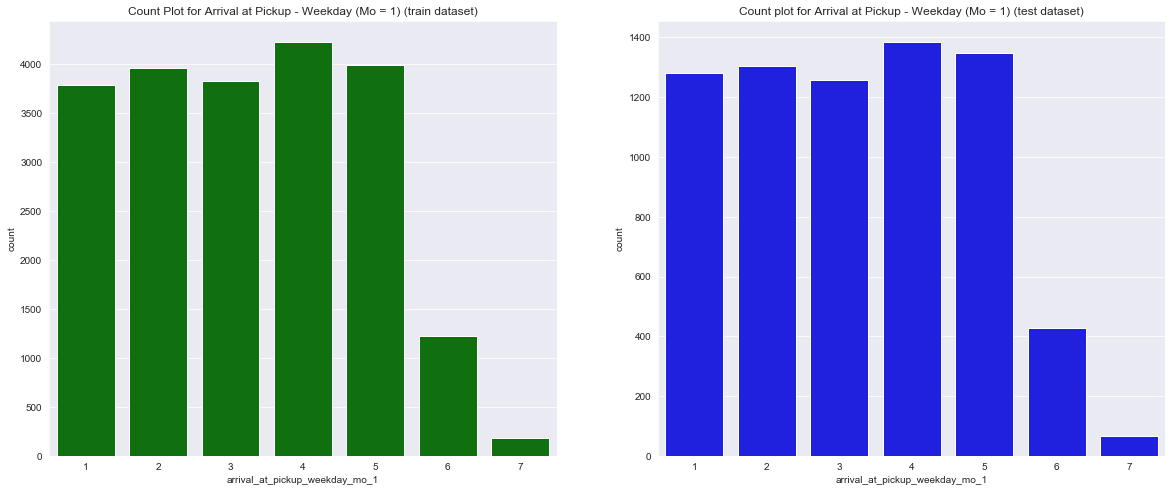

In [373]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
ax[0].set_title('Count Plot for Arrival at Pickup - Weekday (Mo = 1) (train dataset)')
ax[1].set_title('Count plot for Arrival at Pickup - Weekday (Mo = 1) (test dataset)')
sns.countplot(x = 'arrival_at_pickup_weekday_mo_1', data = train, color = 'green', ax=ax[0])
sns.countplot(x = 'arrival_at_pickup_weekday_mo_1', data = test, color = 'blue', ax=ax[1])

According to othe visualization above, the weekend is less busy compared to the other week days. This was expected.

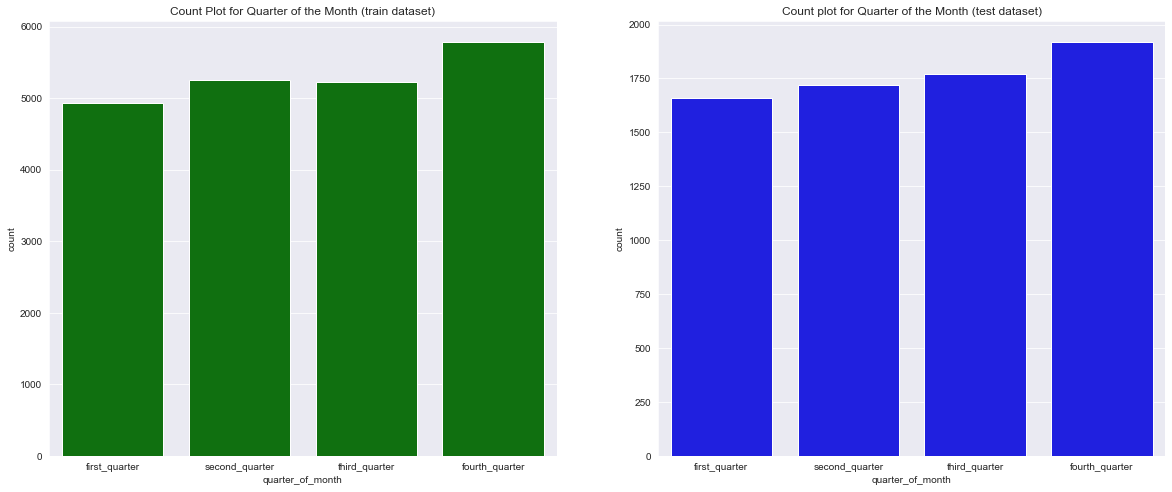

In [374]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
ax[0].set_title('Count Plot for Quarter of the Month (train dataset)')
ax[1].set_title('Count plot for Quarter of the Month (test dataset)')
sns.countplot(x = 'quarter_of_month', data = train, color = 'green', ax=ax[0])
sns.countplot(x = 'quarter_of_month', data = test, color = 'blue', ax=ax[1])

Towards month end traffic does increase as we had anticipated. This can help in our predictions.

### Rider's Features

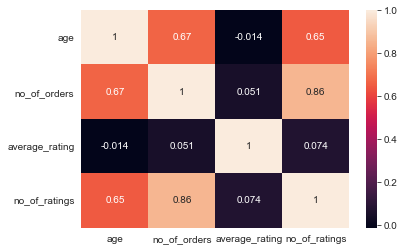

In [375]:
# Merging the (train & test) datasets with the riders dataframe on 'Rider Id'
train = pd.merge(train, riders, on='rider_id', how='left')
test = pd.merge(test, riders, on='rider_id', how='left')

sns.heatmap(train[['age','no_of_orders','average_rating','no_of_ratings']].corr(), annot=True)

It is important to reduce the dimensionality of the rider's data. This is achieved by creating two factor features out of four features. The `rating_factor` is the product between average rating and number of ratings. The `rider_productivity` feature is a ratio between rider's age to number of orders.

This will help standardize the rider's features. For example, you might find that one rider has a high average rating but few number of ratings. On the other hand, one rider has a slightly lower rating with many ratings. At face value one would think the rider with higher average rating is better than the one with a slightly lower rating. However, this is necessarily not the case. To deal with such issues we combine both the rating and number of ratings. The same applies with age and number of orders. 

In [376]:
#Creating new variables that will measure the Rider's Rating and Productivity
train.loc[:, 'rating_factor'] = (train['average_rating'] * train['no_of_ratings'])
test.loc[:, 'rating_factor'] = (test['average_rating'] * test['no_of_ratings'])
train.loc[:, 'rider_productivity'] = (train['age'] / train['no_of_orders'])
test.loc[:, 'rider_productivity'] = (test['age'] / test['no_of_orders'])

### Geospatial Features

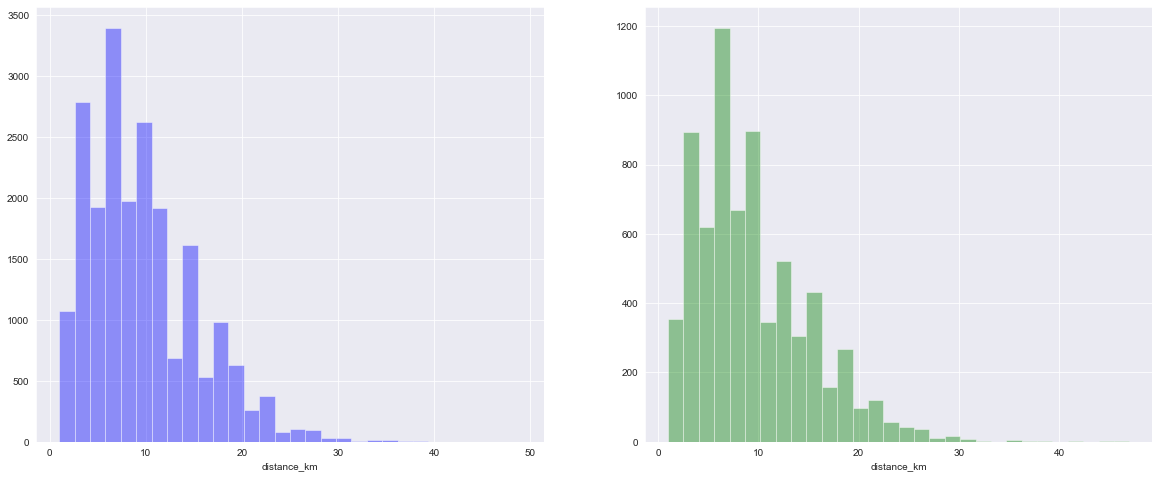

In [377]:
# The distribution of the distance feature
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.distplot(train['distance_km'], bins=30, color='blue', ax = ax[0], kde=False)
sns.distplot(test['distance_km'], bins=30, color='green', ax = ax[1], kde=False)

When predicting travel duration, it is very helpful to have distances between points. It is not known what type of distance is the distance feature in the data, it may well be eucledian. But simple Euclidean distance doesn’t cut it since we have to deal with a sphere, or an oblate spheroid to be exact. So we have to take a look at geodesic distances.

There are various ways to handle this calculation problem. For example there is the Great-circle distance, which is the shortest distance between two points on the surface of a sphere. However, a similar way to measure distances is by using the Haversine formula, which takes the equation: 

$${a} = {hav({Δ}{\theta})} {+} {cos({\phi _{1}})}{.}{cos({\phi _{2}})}{.}{hav({Δ}{\lambda})}$$
                                    
with haversine function




$${hav({\theta})} = {sin}^{2}{\frac{{\theta}} {2}}$$

and takes this to calculate the geodesic distance
$${distance} = {2}{⋅}{R}{⋅}{arctan}{(\sqrt{a} {,} \sqrt{1 + a})}$$

where the latitude is φ, the longitude is denoted as λ and R corresponds to Earths mean radius in kilometers (6371). We can take this formula now and translate it into Python

In [378]:
#Haversine
def haversine(coord1, coord2):
    R = 6372800/1000  # Earth's radius in meters
    lat1, long1 = coord1
    lat2, long2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    delta_phi, delta_lambda = math.radians(lat2 - lat1), math.radians(long2 - long1)
    
    a = math.sin(delta_phi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(delta_lambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

In [379]:
train['haversine_distance'] = ''
test['haversine_distance'] = ''

for i in range(0, len(train.index)):
    coord1 = (train['pickup_lat'].values[i], train['pickup_long'].values[i])
    coord2 = (train['destination_lat'].values[i], train['destination_long'].values[i])
    train['haversine_distance'][i] = haversine(coord1, coord2)

for i in range(0, len(test.index)):
    coord1 = (test['pickup_lat'].values[i], test['pickup_long'].values[i])
    coord2 = (test['destination_lat'].values[i], test['destination_long'].values[i])
    test['haversine_distance'][i] = haversine(coord1, coord2)    

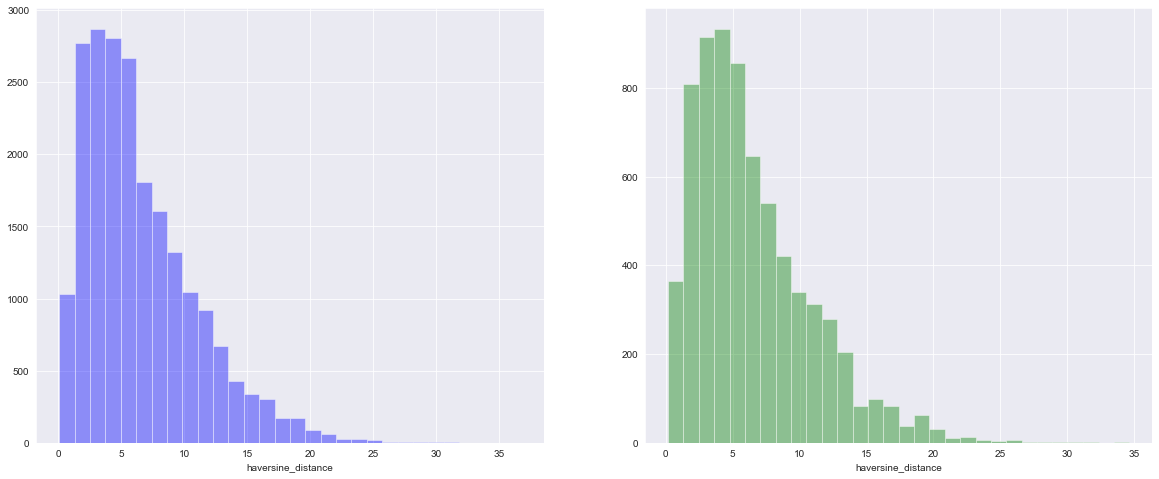

In [380]:
# The distribution of the haversine_distance feature
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.distplot(train['haversine_distance'], bins=30, color='blue', ax = ax[0], kde=False)
sns.distplot(test['haversine_distance'], bins=30, color='green', ax = ax[1], kde=False)

In [381]:
# The mean haversine distance
print('The Eucledian distance mean is equal to {:0.3f}km \n'.format(train['distance_km'].mean()))

# Eucledian distance
print('The Haversine distance mean is equal to {:0.3f}km'.format(train['haversine_distance'].mean()))

The Eucledian distance mean is equal to 9.507km 

The Haversine distance mean is equal to 6.510km


The eucledian distance and the haversine distance are both positively skewed but it is also clear that they do contain some differences.

### Target Feature

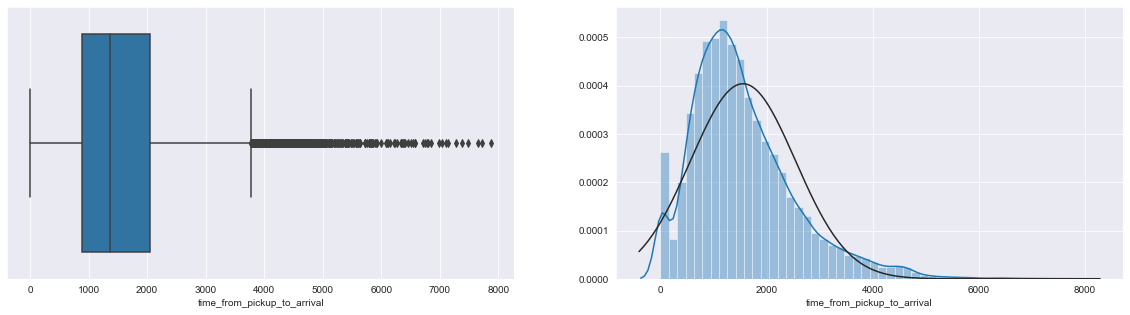

In [382]:
fig,ax = plt.subplots(1,2,figsize=(20,5))
sns.boxplot(train["time_from_pickup_to_arrival"], ax=ax[0])
sns.distplot(train["time_from_pickup_to_arrival"], fit=norm, ax=ax[1])

The `target variable` is **"positively skewed"** and this is mainly caused by a much lower boundary (meaning there are a minority of very large values) in the dataset. This will affect the regression intercept, coefficients associated with the model. This can be fixed in a number of ways including log transformation and boxcox transform. However, in this case, outliers will be dropped.

### Addressing Outliers

Outliers can be filtered out using a `speed` feature. A cutoff speed value will be used to filter outliers.
A maximum speed of about **70 km/h or ~19m/s** will be used as a max threshold value and a minimum speed of **10km/h or 3m/s** as minimum threshold value.

In [383]:
### Calculating the Rider's Speed in m/s
train['speed_meter_per_second'] = (train['distance_km'] * 1000) / train['time_from_pickup_to_arrival']

In [384]:
# train dataset without outliers
train = train[(train['speed_meter_per_second'] <= 19) & (train['speed_meter_per_second'] > 3)]

In [385]:
train.speed_meter_per_second.describe()

count    18233.000000
mean         6.927891
std          2.599744
min          3.000158
25%          5.037783
50%          6.564551
75%          8.285004
max         21.929825
Name: speed_meter_per_second, dtype: float64

### Variable Encoding


In [386]:
display(train.columns)
display(test.columns)

Index(['order_no', 'user_id', 'platform_type', 'personal_or_business',
       'placement_day_of_month', 'placement_weekday_mo_1',
       'confirmation_day_of_month', 'confirmation_weekday_mo_1',
       'arrival_at_pickup_day_of_month', 'arrival_at_pickup_weekday_mo_1',
       'pickup_day_of_month', 'pickup_weekday_mo_1',
       'arrival_at_destination_day_of_month',
       'arrival_at_destination_weekday_mo_1', 'distance_km', 'temperature',
       'pickup_lat', 'pickup_long', 'destination_lat', 'destination_long',
       'rider_id', 'time_from_pickup_to_arrival',
       'placement_to_confirmation_duration',
       'confirmation_to_arrivalpickup_duration',
       'arrivalpickup_to_pickup_duration', 'pickup_hour', 'hour_of _the_day',
       'quarter_of_month', 'no_of_orders', 'age', 'average_rating',
       'no_of_ratings', 'rating_factor', 'rider_productivity',
       'haversine_distance', 'speed_meter_per_second'],
      dtype='object')

Index(['order_no', 'user_id', 'platform_type', 'personal_or_business',
       'placement_day_of_month', 'placement_weekday_mo_1',
       'confirmation_day_of_month', 'confirmation_weekday_mo_1',
       'arrival_at_pickup_day_of_month', 'arrival_at_pickup_weekday_mo_1',
       'pickup_day_of_month', 'pickup_weekday_mo_1', 'distance_km',
       'temperature', 'pickup_lat', 'pickup_long', 'destination_lat',
       'destination_long', 'rider_id', 'placement_to_confirmation_duration',
       'confirmation_to_arrivalpickup_duration',
       'arrivalpickup_to_pickup_duration', 'pickup_hour', 'hour_of _the_day',
       'quarter_of_month', 'no_of_orders', 'age', 'average_rating',
       'no_of_ratings', 'rating_factor', 'rider_productivity',
       'haversine_distance'],
      dtype='object')

In [409]:
# Dropping all the columns we will no longer need
train_cols_drop = ['order_no', 'user_id', 'placement_day_of_month', 'placement_weekday_mo_1',
                   'confirmation_day_of_month', 'confirmation_weekday_mo_1',
                   'arrival_at_pickup_day_of_month', 'arrival_at_pickup_weekday_mo_1',
                  'arrival_at_destination_day_of_month', 'arrival_at_destination_weekday_mo_1',
                  'no_of_orders', 'age', 'average_rating', 'speed_meter_per_second', 'time_from_pickup_to_arrival']

test_cols_drop = ['order_no','user_id', 'placement_day_of_month', 'placement_weekday_mo_1',
                   'confirmation_day_of_month', 'confirmation_weekday_mo_1',
                   'arrival_at_pickup_day_of_month', 'arrival_at_pickup_weekday_mo_1',
                 'no_of_orders', 'age', 'average_rating']

train['platform_type'] = train['platform_type'].astype('category')
train['pickup_weekday_mo_1'] = train['pickup_weekday_mo_1'].astype('category')
train['haversine_distance'] = train['haversine_distance'].astype('float64')
test['platform_type'] = test['platform_type'].astype('category')
test['pickup_weekday_mo_1'] = test['pickup_weekday_mo_1'].astype('category')
test['haversine_distance'] = test['haversine_distance'].astype('float64')


y_data = train['time_from_pickup_to_arrival']# Target variable
X_data = train.drop(train_cols_drop, axis=1) #Predictors
X_test = test.drop(test_cols_drop, axis=1)
X_test_order_no = test['order_no']

In [410]:
train['haversine_distance'].head()

0     1.930879
1    11.343053
2     1.880610
3     4.944855
4     3.725881
Name: haversine_distance, dtype: float64

In [411]:
display(X_data.dtypes)
display(X_test.dtypes)
display(X_test.columns == X_data.columns)

platform_type                             category
personal_or_business                        object
pickup_day_of_month                          int64
pickup_weekday_mo_1                       category
distance_km                                  int64
temperature                                float64
pickup_lat                                 float64
pickup_long                                float64
destination_lat                            float64
destination_long                           float64
rider_id                                    object
placement_to_confirmation_duration         float64
confirmation_to_arrivalpickup_duration     float64
arrivalpickup_to_pickup_duration           float64
pickup_hour                                  int64
hour_of _the_day                          category
quarter_of_month                          category
no_of_ratings                                int64
rating_factor                              float64
rider_productivity             

platform_type                             category
personal_or_business                        object
pickup_day_of_month                          int64
pickup_weekday_mo_1                       category
distance_km                                  int64
temperature                                float64
pickup_lat                                 float64
pickup_long                                float64
destination_lat                            float64
destination_long                           float64
rider_id                                    object
placement_to_confirmation_duration         float64
confirmation_to_arrivalpickup_duration     float64
arrivalpickup_to_pickup_duration           float64
pickup_hour                                  int64
hour_of _the_day                          category
quarter_of_month                          category
no_of_ratings                                int64
rating_factor                              float64
rider_productivity             

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

`OneHotEncoder` is preferred over pandas `get_dummies`. The crux of it is that the sklearn encoder creates a function which persists and can then be applied to new data sets which use the same categorical variables, with consistent results.

In [412]:
#Feature Encoding
oce = ce.OneHotEncoder(cols=['platform_type','personal_or_business','hour_of _the_day', 'quarter_of_month'])
hce = ce.TargetEncoder(cols=['rider_id'], smoothing = 40, min_samples_leaf = 7)

X_data = oce.fit_transform(X_data)
X_data = hce.fit_transform(X_data,y_data)
X_test = oce.transform(X_test)
X_test = hce.transform(X_test)

### Feature Importance

In [413]:
# Normalize data
X_data_2 = X_data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_data_2)
X_normalize = pd.DataFrame(X_scaled, columns=X_data_2.columns)


# Create VarianceThreshold object
selector = VarianceThreshold(threshold=0.05)

# Use the object to apply the threshold on data
selector.fit(X_normalize)

# Get column variances
column_variances = selector.variances_

vars_dict = {}
vars_dict = [{"Variable_Name": c_name, "Variance": c_var}
             for c_name, c_var in zip(X_normalize.columns, column_variances)]
df_vars = pd.DataFrame(vars_dict)
df_vars.sort_values(by='Variance', ascending=False)

,Variable_Name,Variance
19,hour_of _the_day_1,0.234219
22,hour_of _the_day_4,0.203387
27,quarter_of_month_4,0.198132
26,quarter_of_month_3,0.186502
25,quarter_of_month_2,0.185753
24,quarter_of_month_1,0.178820
21,hour_of _the_day_3,0.178351
4,personal_or_business_1,0.155044
5,personal_or_business_2,0.155044
0,platform_type_1,0.133605


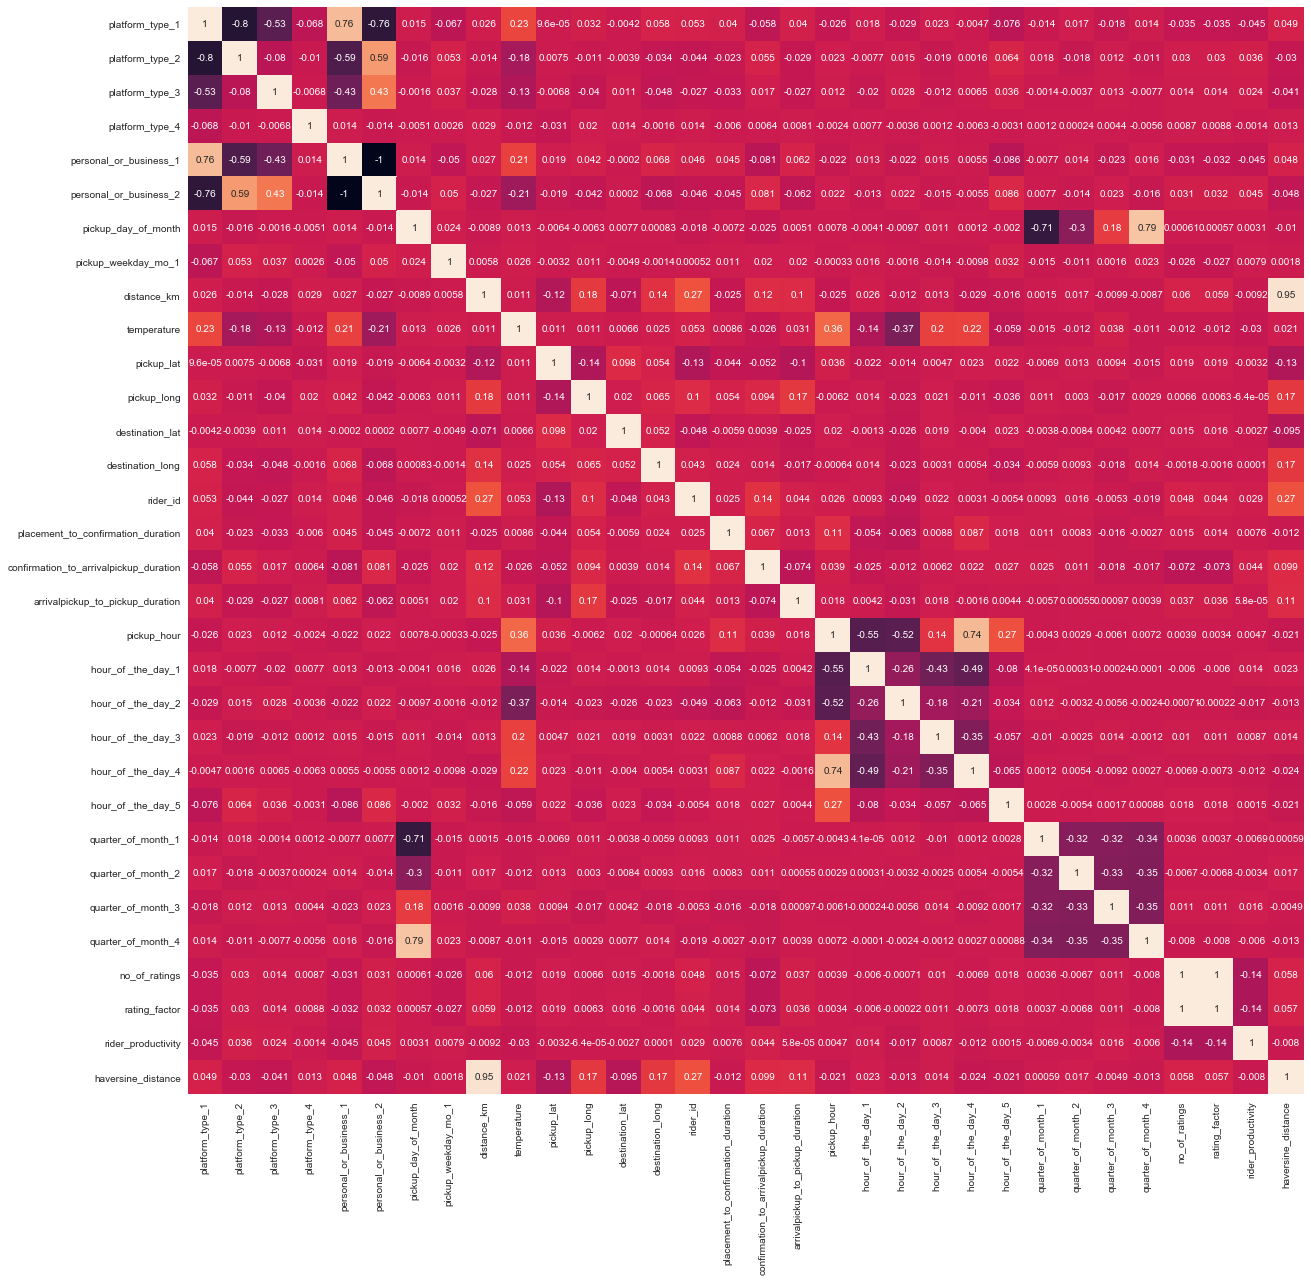

In [414]:
# Let us check the correlation
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(X_normalize.corr(), annot=True, cbar=False)

# Modelling

### Our Chosen Models

In [ ]:
# To be added




In [ ]:
# 10-Fold Cross Validation scheme
nfolds = 10
kfolds=KFold(n_splits=nfolds, shuffle=True, random_state=10)

In [ ]:
def initializer():
    train_fold = np.zeros((len(X_data)))
    test_fold = np.zeros((len(X_test)))
    cross_val_scores = [] 
    training_scores=[]
    testing_scores=[]


# The function fits our models
def model_fitting(model, model_name, X, y):   
    initializer()
    for index, (train_index, valuation_index) in (enumerate(kfolds.split(X, y))): 
        X_train, X_valuation = X.iloc[train_index], X.iloc[valuation_index] 
        y_train, y_valuation = y.iloc[train_index], y.iloc[valuation_index]
        model.fit(X_train, y_train)
        valuation_pred = model.predict(X_valuation)
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test) #predict by fold on the test
        test_fold += test_pred  # contains for each fold predictions for the whole test
        train_fold[valuation_index] += valuation_pred
        cross_validation_RMSE = np.sqrt(mean_squared_error(y_valuation, valuation_pred))
        train_RMSE = np.sqrt(mean_squared_error(y_train, train_pred))
        training_scores.append(train_RMSE)
        cross_val_scores.append(cross_validation_RMSE)
        print(f'Iteration : {str(index+1)} - Training {model_name} Score : {train_RMSE} - Cross_Validation {model_name} Score : {cross_validation_RMSE}')
    final_training_score = np.mean(train_scores)
    final_cross_val_score = np.mean(cv_scores)

    print(f'final_training_score : {final_training_score} -  final_cross_val_score : {final_cross_val_score} ')
    
    return train_fold, test_fold